## Simple shear experiment

The primary goal of this notebook is to demonstrate the formation of shear bands as a function of accumulating shear strain in a model with a softening frictional rheology. It also shows some strategies for visualising the shear bands.

We consider a periodic domain with plastic-strain-softening, Drucker-Prager rheology which is subject to simple shear boundary conditions (the top and the bottom of the domain are driven at constant velocity in opposite directions.

The rheology is described by:

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau_\textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}
where the yield stress, $\tau_\textrm{yield}$ is given by

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

$ \left| \, \dot\varepsilon \, \right| $ is the second invariant of the strain rate tensor, $\varepsilon$ is its integral over time in regions where the yield stress is reached, $C$ is a cohesion, $\mu$ is a friction coefficient, and $p$ is the pressure.

The cohesion weakens with accumulated plastic strain as follows:

\begin{equation}
    C = c_0 + c_1 e^{ \left( -\varepsilon_\textrm{p} / \varepsilon_0 \right)}
\end{equation}

No healing of the cohesion is implemented in this example.




In [1]:
import underworld as uw
import numpy as np
import math
import os
from underworld import function as fn
import glucifer

In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/SimpleShear2D/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [3]:
minX = 0.0
maxX = 4.0
resX = 192
resY = 48
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, 1.),
                                 periodic    = [True, False]  ) 


velocityField    = mesh.add_variable(         nodeDofCount=mesh.dim )
pressureField    = mesh.subMesh.add_variable( nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Simple shear with periodic (wrap-around) walls in the _x_ direction

In [4]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

#velocityField.data[mesh.specialSets["MinJ_VertexSet"]] = 0.
for index in mesh.specialSets["MinJ_VertexSet"]:
    velocityField.data[index] = [-0.5, 0.]
for index in mesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index] = [0.5, 0.]
    
BCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                        indexSetsPerDof = ( jWalls, jWalls) ) 

### Setup the material swarm

This is used for tracking deformation and history dependence of the rheology

In [5]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=30 )
swarm.populate_using_layout( layout=swarmLayout )

deformationSwarm = uw.swarm.Swarm ( mesh=mesh )

### Create a particle advection system

Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

In [6]:
advector  = uw.systems.SwarmAdvector( swarm=swarm,            velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=deformationSwarm, velocityField=velocityField, order=2 )

### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.

**NOTE**:  Underworld needs all the swarm variables defined before they are initialised or there will be / can be memory problems (at least it complains about them !). That means we need to add the monitoring variables now, even if we don't always need them.

In [7]:
plasticStrain  = swarm.add_variable( dataType="double",  count=1 )

# These ones are for monitoring of the shear bands

stretching = swarm.add_variable( dataType="double", count=mesh.dim)
orientation = swarm.add_variable( dataType="double", count=1)

deformationVariable = deformationSwarm.add_variable( dataType="double", count=1)

### Initialise swarm variables



In [8]:
# Stretching - assume an initial orientation aligned with the x-axis

stretching.data[:,0] = 1.0
stretching.data[:,1] = 0.0

# This is a work-variable for visualisation

orientation.data[:] = 0.0

# plastic strain - random initial value with an envelope to ensure the 
# localisation stays clear of the boundary = the same function will be used
# later to suppress the plastic strain weakening close to the boundaries. 

def boundary(xx, width, power):
    return (np.tanh(xx*width) + np.tanh((1.0-xx)*width) - math.tanh(width))**power

weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4)

plasticStrain.data[:] = 0.05 * np.random.rand(*plasticStrain.data.shape[:])
plasticStrain.data[:,0] *= weight

deformationPoints = np.array(np.meshgrid(np.linspace(minX+0.01, maxX-0.01, 50), np.linspace(0.1, 0.8, 100))).T.reshape(-1,2)
deformationSwarm.add_particles_with_coordinates( deformationPoints )

pass

### Define the viscosity function

In this case, the viscosity of material which has not reached the yield criterion is simply going to be a constant. Nevertheless, it is useful to define it here as a function and write the remaining code such that it is not changed if we introduce additional materials or a dependence on another set of equations.



In [9]:
viscosity0  = 1.0

backgroundViscosityFn = fn.misc.constant(viscosity0)

### Define a yield criterion (function)

\begin{equation}
    \tau_\textrm{yield} = C(\varepsilon_p) + \mu p 
\end{equation}

The yield strength described above needs to be evaluated on the fly at the particles (integration points). It therefore needs to be a function composed of mesh variables, swarm variables, constants, and mathematical operations.


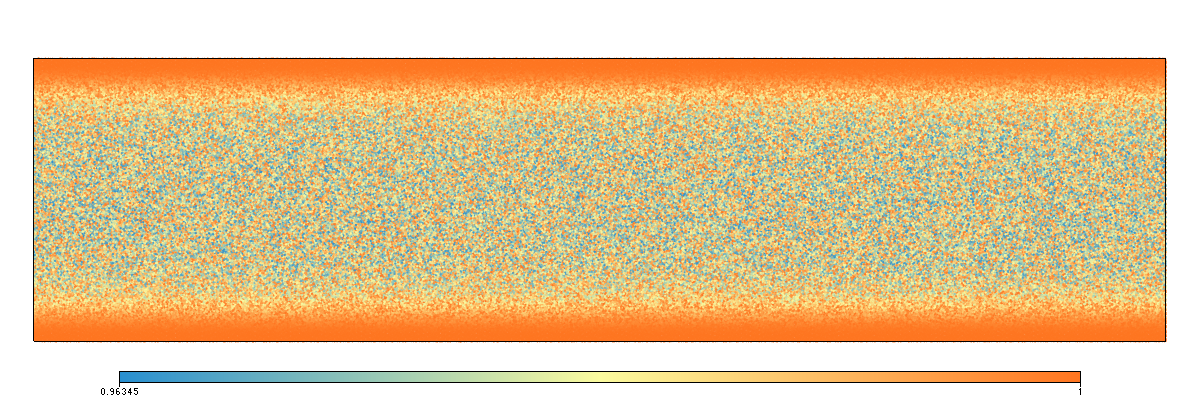

In [10]:
# Cohesion - a function of swarm variables

cohesionInf     = fn.misc.constant(0.25)
cohesion0       = fn.misc.constant(0.75)
referenceStrain = fn.misc.constant(1.0)

cohesionFn =  cohesionInf + cohesion0 * fn.math.exp(-plasticStrain / referenceStrain )

# Friction - in this form it could also be made to weaken with strain

frictionInf     = fn.misc.constant(0.5)
frictionFn      = frictionInf 


# Drucker-Prager yield criterion

yieldStressFn   = cohesionFn + frictionFn * pressureField


# Plot it and see (it will be the cohesion in the first run through) 

figYieldStress = glucifer.Figure( figsize=(1200,400) )
figYieldStress.append( glucifer.objects.Points(swarm, yieldStressFn , pointSize=3.0) )
figYieldStress.show()

### Define composite (yielding) rheology

The actual constitutive behaviour is a composite of the behaviour below the yield strength and the reduced viscosity required to ensure that the stress remains bounded by the yield envelope.

\begin{equation}
    \eta =  
        \begin{cases}
              \eta_0 & |\tau| < \tau_\textrm{yield} \\
              {\tau _ \textrm{yield}} / {2 \left| \, \dot\varepsilon \, \right|} & \textrm{otherwise}
        \end{cases}
\end{equation}

**Note**: The $1.0^{-18}$ added to the strain-rate is supposed to be a small number preventing the rheology from blowing up if the velocity field is zero. Obviously this number should be much smaller than the expected strain rate !

In [11]:
# first define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

# now compute a viscosity assuming yielding

min_viscosity = 0.001

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+1.0e-18)

viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
                                                              backgroundViscosityFn), 
                                                  min_viscosity))


### Deviatoric stress 

The deviatoric stress is computed from the constitutive law based on the viscosity that
results from the solution to the non-linear Stokes equation.

**Note:** the deviatoric stress is defined in terms of functions we have defined already
but the value will be meaningless if the viscosityFn is modified in any way after the 
solve is complete because evaluation is made only when the values at particular points are needed.

In [12]:
devStressFn = 2.0 * viscosityFn * strainRateFn

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [13]:
z_hat   = ( 0.0, 0.0 )
buoyancyFn = z_hat 

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [14]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = BCs,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = None )


solver = uw.systems.Solver( stokes )

# "mumps" is a good alternative for "lu" but 
# not every petsc installation has mumps !
# It also works fine in parallel

# use "lu" direct solve and large penalty (if running in serial)
if(uw.nProcs()==1):
    solver.set_inner_method("lu")
    solver.set_penalty(1.0e6) 
    
    
solver.options.scr.ksp_rtol = 1.0e-3

# Test to see if these setting are OK

solver.solve( nonLinearIterate=True )
solver.print_stats()



 
Pressure iterations:   2
Velocity iterations:   1 (presolve)      
Velocity iterations:   2 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   4 (total solve)   
 
SCR RHS  setup time: 1.5064e-01
SCR RHS  solve time: 2.1083e-03
Pressure setup time: 9.3222e-04
Pressure solve time: 5.0015e-03
Velocity setup time: 4.2915e-06 (backsolve)
Velocity solve time: 2.1420e-03 (backsolve)
Total solve time   : 1.8167e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 




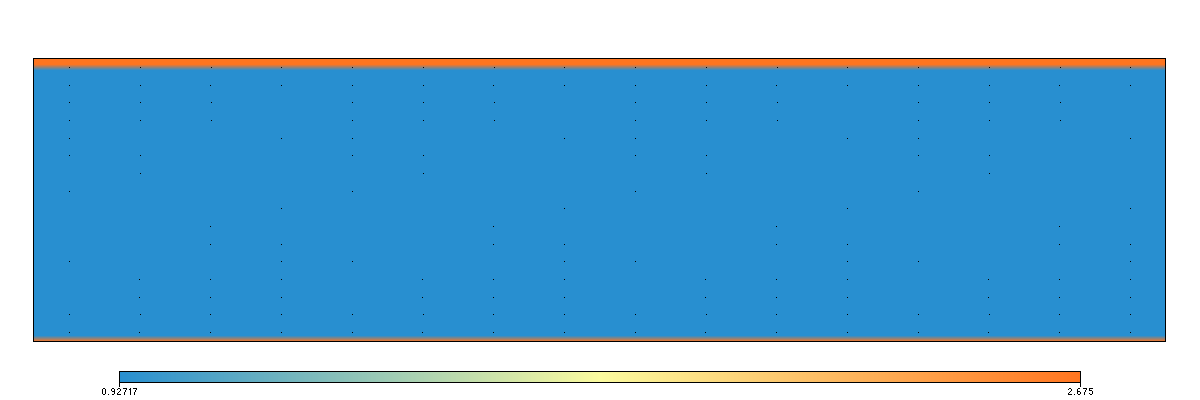

In [15]:
velocityFieldAnomaly = velocityField.copy()
velocityFieldAnomaly = velocityField - ( 1.0, 0.0 ) * (fn.input()[1] - 0.5)

curlV = velocityField.fn_gradient[1] - velocityField.fn_gradient[2]

figStrainRate2 = glucifer.Figure(figsize=(1200, 400))
figStrainRate2.append( glucifer.objects.VectorArrows(mesh, velocityFieldAnomaly, scaling=.1) )
figStrainRate2.append( glucifer.objects.Surface(mesh, curlV) )
figStrainRate2.show()



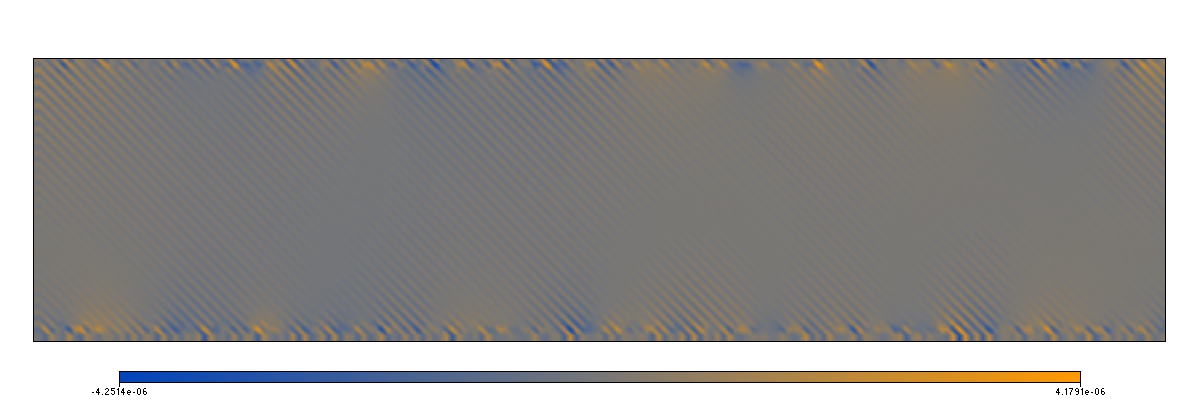

In [16]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help for visualisation purposes

meshDevStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()

figMeshStress = glucifer.Figure( figsize=(1200, 400))
figMeshStress.append( glucifer.objects.Surface(mesh, pressureField  , colours="#0044BB, #777777, #FF9900") )
figMeshStress.show()


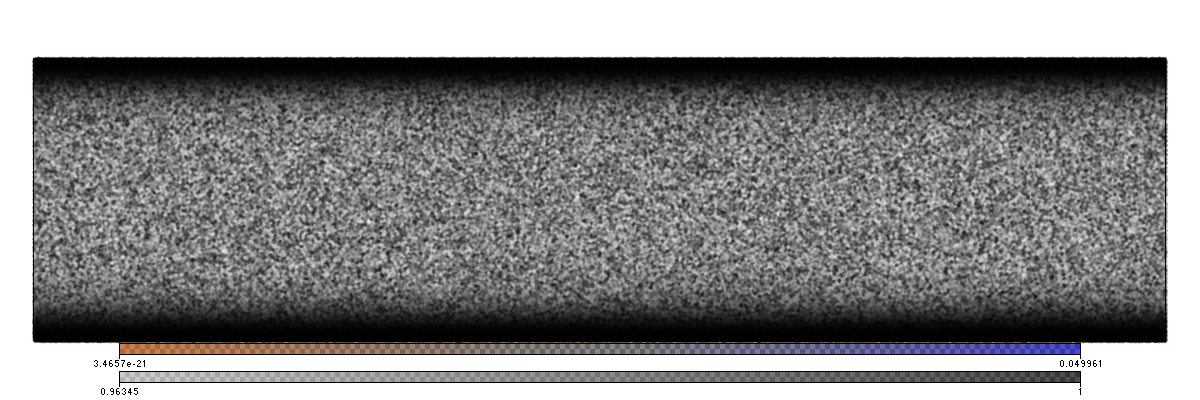

In [17]:
figStrain = glucifer.Figure( figsize=(1200, 400))
figStrain.append( glucifer.objects.Points(swarm, cohesionFn, pointSize=5.0, colours="white:0.5 black:0.5") )
figStrain.append( glucifer.objects.Points(swarm, plasticStrain, pointSize=4.0,  colours="#FF6600:0.5, #555555:0.25, Blue:0.5") )
figStrain.show()

## Main simulation loop
-----

In [18]:
def update():
    # get timestep
    dt = advector.get_max_dt()
    
    # advect particles
    advector.integrate(dt)
    advector2.integrate(dt)

    # update stretching metric
    swarmVgrad = velocityField.fn_gradient.evaluate(swarm)
    stretching.data[:,0] += dt * (swarmVgrad[:,0] * stretching.data[:,0] + swarmVgrad[:,1] * stretching.data[:,1])
    stretching.data[:,1] += dt * (swarmVgrad[:,2] * stretching.data[:,0] + swarmVgrad[:,3] * stretching.data[:,1])
        
    # plastic strain update
    swarmViscosity = viscosityFn.evaluate(swarm)
    swarmStrainRateInv = strainRate_2ndInvariantFn.evaluate(swarm)
    weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4)
    plasticStrainIncrement = dt * np.where( swarmViscosity < viscosity0, swarmStrainRateInv , 0.0 )
    plasticStrainIncrement[:,0] *= weight
    plasticStrain.data[:] += plasticStrainIncrement
    
    return time+dt, step+1

In [19]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0
nsteps = 10
frictionValueAsString = str(frictionInf.evaluate([0.0,0.0])[0,0]) # 

while step<nsteps:
    solver.solve( nonLinearIterate=True )

    if (step%5 ==0):
               
        figStrainRate2.save_image( outputPath + "figStrainRate-" +
                                   frictionValueAsString + "-" + str(step).zfill(4))
        
        figYieldStress.save_image( outputPath + "figStrength-" +                
                                   frictionValueAsString + "-" + str(step).zfill(4))
        
    if uw.rank()==0:
        print('step = {0:6d}; time = {1:.3e};'.format(step,time))
        print("Plastic Strain - max = {}".format(plasticStrain.evaluate(swarm).max()))

    # finished with timestep, let's update
    time, step = update()

step =      0; time = 0.000e+00;
Plastic Strain - max = 0.0499604869302
step =      1; time = 2.083e-02;
Plastic Strain - max = 0.0499604869302
step =      2; time = 4.167e-02;
Plastic Strain - max = 0.0499604869302
step =      3; time = 6.250e-02;
Plastic Strain - max = 0.0499604869302
step =      4; time = 8.333e-02;
Plastic Strain - max = 0.0600059429129
step =      5; time = 1.042e-01;
Plastic Strain - max = 0.0701126959222
step =      6; time = 1.250e-01;
Plastic Strain - max = 0.0802856201736
step =      7; time = 1.458e-01;
Plastic Strain - max = 0.0905590150107
step =      8; time = 1.667e-01;
Plastic Strain - max = 0.100967254559
step =      9; time = 1.875e-01;
Plastic Strain - max = 0.11158752683


Post simulation analysis
-----

**Note**: Because `figCohesion` is defined entirely in terms of StGermain functions, it will automatically plot the latest version of the cohesion evaluated at each of the particle locations. This is not true of the figure which has to compute the velocity anomaly. The reason for this is that the function interface does not (yet) have the capacity to manipulate the velocity as required.


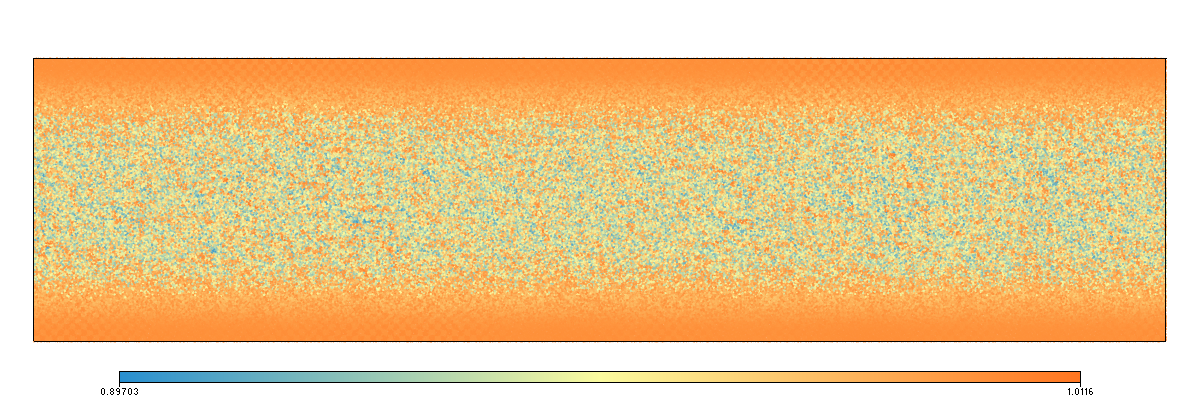

In [20]:
figYieldStress.show()


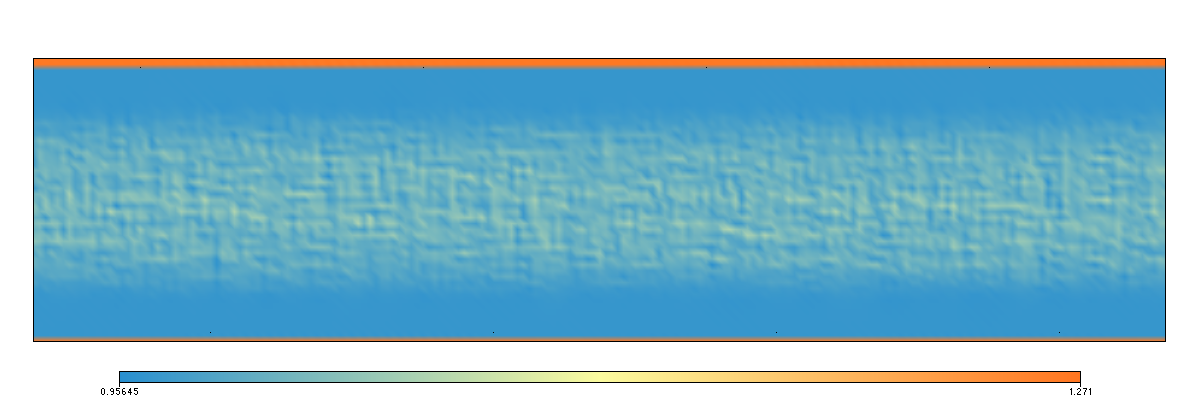

In [21]:
figStrainRate2.show()


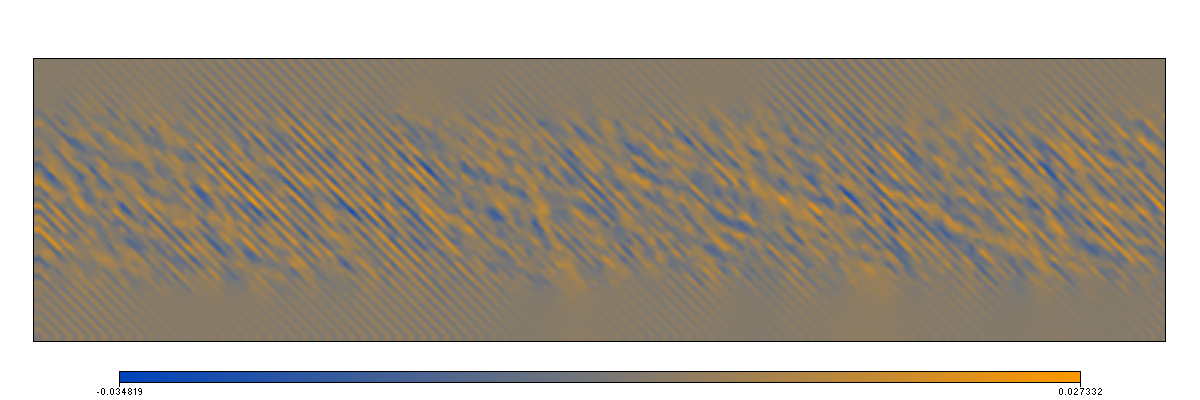

In [22]:
projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=1 )
projectorStress.solve()

figMeshStress.show()


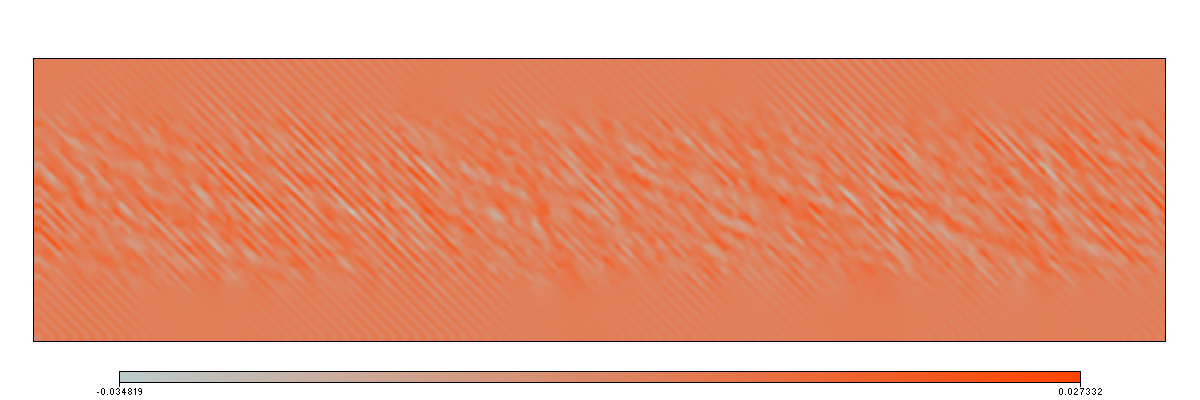

In [23]:
figPressure = glucifer.Figure(figsize=(1200, 400))
figPressure.append( glucifer.objects.Surface(mesh, pressureField, colours="#BBCCCC, #FF4400") )
figPressure.show()

### Particle shear-strain measure

An initially horizontal line will be stretched along the direction of shear strain. This is one way to identify the shear bands but it's not particularly helpful for this example !


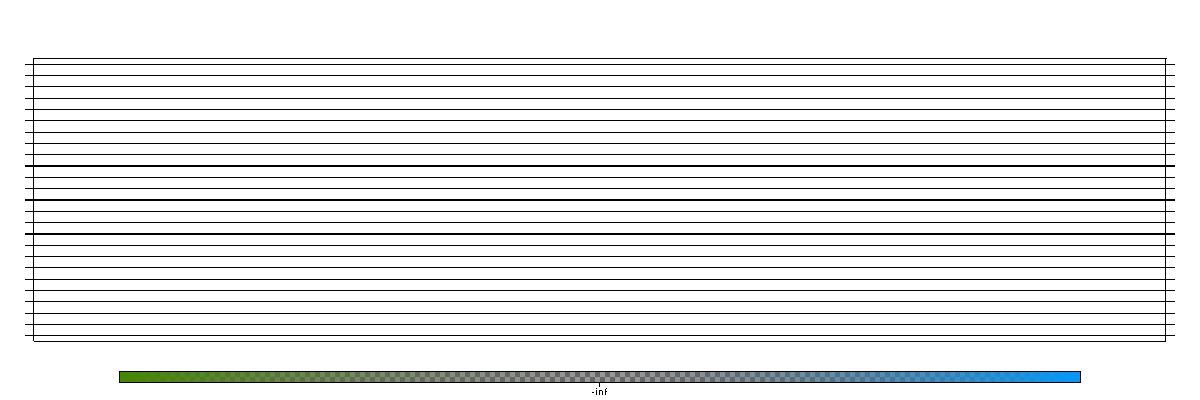

In [26]:
swarmVgrad = velocityField.fn_gradient.evaluate(swarm)

meshStretching = mesh.add_variable( 2 )

orientation.data[:,0] = np.where( np.abs(swarmVgrad[:,0]) > 1.1, -180 * np.arctan2(stretching.data[:,1] / math.pi, stretching.data[:,0]) / math.pi, 0.0)

projectStretching = uw.utils.MeshVariable_Projection( meshStretching, stretching, type=0 )
projectStretching.solve()
meshStretching.data[:,0] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )
meshStretching.data[:,1] /= np.sqrt( meshStretching.data[:,0]**2 + meshStretching.data[:,1]**2 )

figMeshStretching = glucifer.Figure( figsize=(1200, 400))
figMeshStretching.append( glucifer.objects.VectorArrows(mesh, meshStretching, scaling=0.1, arrowHead=0.00001, resolution=[100,25,1])) 
figMeshStretching.append( glucifer.objects.Points(swarm, orientation , pointSize=5.0, colours="#448800, #666666:0.0, #0099FF") )
figMeshStretching.show()
